In [1]:
# Manage data and statistics
import numpy as np
from numpy.random import default_rng, SeedSequence
import pandas as pd
from pandas.api.types import CategoricalDtype

from scipy import stats
from scipy.stats.mstats import winsorize

# Plot data
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
mpl.style.use('tableau-colorblind10')

import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

# statsmodels
import patsy
from patsy import dmatrices
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

# scikit-learn
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

## Read `Credit` dataset

In [2]:
credit = pd.read_csv('https://raw.githubusercontent.com/cbrownley/2022MLWEEK_MLWITHPYTHON/main/data/Credit.csv')
credit

,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region,Balance
0,14.891,3606,283,2,34,11,No,No,Yes,South,333
1,106.025,6645,483,3,82,15,Yes,Yes,Yes,West,903
2,104.593,7075,514,4,71,11,No,No,No,West,580
3,148.924,9504,681,3,36,11,Yes,No,No,West,964
4,55.882,4897,357,2,68,16,No,No,Yes,South,331
...,...,...,...,...,...,...,...,...,...,...,...
395,12.096,4100,307,3,32,13,No,No,Yes,South,560
396,13.364,3838,296,5,65,17,No,No,No,East,480
397,57.872,4171,321,5,67,12,Yes,No,Yes,South,138
398,37.728,2525,192,1,44,13,No,No,Yes,South,0


## Check data types and values

In [ ]:
credit.dtypes

Income       float64
Limit          int64
Rating         int64
Cards          int64
Age            int64
Education      int64
Own           object
Student       object
Married       object
Region        object
Balance        int64
dtype: object

In [ ]:
credit.describe().round(1)

,Income,Limit,Rating,Cards,Age,Education,Balance
count,400.0,400.0,400.0,400.0,400.0,400.0,400.0
mean,45.2,4735.6,354.9,3.0,55.7,13.4,520.0
std,35.2,2308.2,154.7,1.4,17.2,3.1,459.8
min,10.4,855.0,93.0,1.0,23.0,5.0,0.0
25%,21.0,3088.0,247.2,2.0,41.8,11.0,68.8
50%,33.1,4622.5,344.0,3.0,56.0,14.0,459.5
75%,57.5,5872.8,437.2,4.0,70.0,16.0,863.0
max,186.6,13913.0,982.0,9.0,98.0,20.0,1999.0


In [ ]:
credit.Own.value_counts()

Yes    207
No     193
Name: Own, dtype: int64

In [ ]:
credit.Student.value_counts()

No     360
Yes     40
Name: Student, dtype: int64

In [ ]:
credit.Married.value_counts()

Yes    245
No     155
Name: Married, dtype: int64

In [ ]:
credit.Region.value_counts()

South    199
West     102
East      99
Name: Region, dtype: int64

## Create dummy indicator variables

In [ ]:
credit['Own'] = np.where(credit['Own'] == 'Yes', 1.0, 0.0)

In [ ]:
credit['Student'] = np.where(credit['Student'] == 'Yes', 1.0, 0.0)

In [ ]:
credit['Married'] = np.where(credit['Married'] == 'Yes', 1.0, 0.0)

In [ ]:
credit = pd.get_dummies(data=credit, columns=['Region'], prefix='Region', drop_first=True, dtype=float)
credit

,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Balance,Region_South,Region_West
0,14.891,3606,283,2,34,11,0.0,0.0,1.0,333,1.0,0.0
1,106.025,6645,483,3,82,15,1.0,1.0,1.0,903,0.0,1.0
2,104.593,7075,514,4,71,11,0.0,0.0,0.0,580,0.0,1.0
3,148.924,9504,681,3,36,11,1.0,0.0,0.0,964,0.0,1.0
4,55.882,4897,357,2,68,16,0.0,0.0,1.0,331,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
395,12.096,4100,307,3,32,13,0.0,0.0,1.0,560,1.0,0.0
396,13.364,3838,296,5,65,17,0.0,0.0,0.0,480,0.0,0.0
397,57.872,4171,321,5,67,12,1.0,0.0,1.0,138,1.0,0.0
398,37.728,2525,192,1,44,13,0.0,0.0,1.0,0,1.0,0.0


## Center and Scale numeric predictors

In [ ]:
numeric_predictors = ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Own', 'Student', 'Married', 'Region_South', 'Region_West']

credit[numeric_predictors] = (credit[numeric_predictors] - credit[numeric_predictors].mean()) / credit[numeric_predictors].std()

credit

,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Balance,Region_South,Region_West
0,-0.860505,-0.489386,-0.464957,-0.698255,-1.256101,-0.783948,-1.034339,-0.332916,0.794400,333,1.003756,-0.584317
1,1.725276,0.827225,0.827667,0.030993,1.526539,0.495967,0.964384,2.996248,0.794400,903,-0.993768,1.707122
2,1.684646,1.013518,1.028023,0.760241,0.888851,-0.783948,-1.034339,-0.332916,-1.255665,580,-0.993768,1.707122
3,2.942467,2.065853,2.107363,0.030993,-1.140158,-0.783948,0.964384,-0.332916,-1.255665,964,-0.993768,1.707122
4,0.302549,0.069925,0.013314,-0.698255,0.714936,0.815946,-1.034339,-0.332916,0.794400,331,1.003756,-0.584317
...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.939809,-0.275366,-0.309842,0.030993,-1.372044,-0.143990,-1.034339,-0.332916,0.794400,560,1.003756,-0.584317
396,-0.903832,-0.388875,-0.380936,1.489490,0.541021,1.135925,-1.034339,-0.332916,-1.255665,480,-0.993768,-0.584317
397,0.359012,-0.244606,-0.219358,1.489490,0.656964,-0.463969,0.964384,-0.332916,0.794400,138,1.003756,-0.584317
398,-0.212542,-0.957716,-1.053100,-1.427504,-0.676384,-0.143990,-1.034339,-0.332916,0.794400,0,1.003756,-0.584317


In [ ]:
credit.describe().round(1)

,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Balance,Region_South,Region_West
count,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
mean,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,520.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,459.8,1.0,1.0
min,-1.0,-1.7,-1.7,-1.4,-1.9,-2.7,-1.0,-0.3,-1.3,0.0,-1.0,-0.6
25%,-0.7,-0.7,-0.7,-0.7,-0.8,-0.8,-1.0,-0.3,-1.3,68.8,-1.0,-0.6
50%,-0.3,-0.0,-0.1,0.0,0.0,0.2,1.0,-0.3,0.8,459.5,-1.0,-0.6
75%,0.3,0.5,0.5,0.8,0.8,0.8,1.0,-0.3,0.8,863.0,1.0,1.7
max,4.0,4.0,4.1,4.4,2.5,2.1,1.0,3.0,0.8,1999.0,1.0,1.7


## `statsmodels`: OLS regression using R-style formulas

In [ ]:
# SOURCE: https://www.statsmodels.org/stable/example_formulas.html

# Describe model
mod = smf.ols(formula='Balance ~ Income + Limit + Rating + Cards + Age + Education + Own + Student + Married + Region_South + Region_West', data=credit)

# Fit model
res = mod.fit()

# Summarize model
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     750.3
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          1.11e-253
Time:                        03:33:21   Log-Likelihood:                -2398.7
No. Observations:                 400   AIC:                             4821.
Df Residuals:                     388   BIC:                             4869.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      520.0150      4.940    105.276   

In [ ]:
# Check that Intercept equals mean Balance (since all predictors were standardized)
np.round(credit.Balance.mean(), decimals=3)

520.015

## `statsmodels`: OLS regression using design matrices

In [ ]:
# SOURCE: https://www.statsmodels.org/stable/gettingstarted.html

y, X = dmatrices('Balance ~ Income + Limit + Rating + Cards + Age + Education + Own + Student + Married + Region_South + Region_West', data=credit, return_type='dataframe')

In [ ]:
y[:3]

,Balance
0,333.0
1,903.0
2,580.0


In [ ]:
X[:3]

,Intercept,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region_South,Region_West
0,1.0,-0.860505,-0.489386,-0.464957,-0.698255,-1.256101,-0.783948,-1.034339,-0.332916,0.794400,1.003756,-0.584317
1,1.0,1.725276,0.827225,0.827667,0.030993,1.526539,0.495967,0.964384,2.996248,0.794400,-0.993768,1.707122
2,1.0,1.684646,1.013518,1.028023,0.760241,0.888851,-0.783948,-1.034339,-0.332916,-1.255665,-0.993768,1.707122


In [ ]:
# Describe model
mod = sm.OLS(y, X)

# Fit model
res = mod.fit()

# Summarize model
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     750.3
Date:                Thu, 02 Jun 2022   Prob (F-statistic):          1.11e-253
Time:                        05:42:28   Log-Likelihood:                -2398.7
No. Observations:                 400   AIC:                             4821.
Df Residuals:                     388   BIC:                             4869.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      520.0150      4.940    105.276   

## `scikit-learn`: OLS regression

In [ ]:
ols_reg = LinearRegression(fit_intercept=False)

ols_reg.fit(X, y)

LinearRegression(fit_intercept=False)

In [ ]:
predictors = ['Intercept', 'Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Own', 'Student', 'Married', 'Region_South', 'Region_West']


ols_coefs = pd.DataFrame.from_dict( dict(zip(predictors, [np.round(val, 3) for val in ols_reg.coef_.flatten()])), orient='index')
ols_coefs.columns = ['coef']
ols_coefs

,coef
Intercept,520.015
Income,-275.015
Limit,440.651
Rating,175.848
Cards,24.305
Age,-10.590
Education,-3.434
Own,-5.330
Student,127.884
Married,-4.163


## `scikit-learn`: Ridge regression

In [ ]:
# SOURCE 1: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
# SOURCE 2: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html#sphx-glr-auto-examples-linear-model-plot-ridge-path-py

# Create alphas (regularization strength)
n_alphas = 200
r_alphas = np.logspace(-3, 5, n_alphas)
r_alphas

array([1.00000000e-03, 1.09698580e-03, 1.20337784e-03, 1.32008840e-03,
       1.44811823e-03, 1.58856513e-03, 1.74263339e-03, 1.91164408e-03,
       2.09704640e-03, 2.30043012e-03, 2.52353917e-03, 2.76828663e-03,
       3.03677112e-03, 3.33129479e-03, 3.65438307e-03, 4.00880633e-03,
       4.39760361e-03, 4.82410870e-03, 5.29197874e-03, 5.80522552e-03,
       6.36824994e-03, 6.98587975e-03, 7.66341087e-03, 8.40665289e-03,
       9.22197882e-03, 1.01163798e-02, 1.10975250e-02, 1.21738273e-02,
       1.33545156e-02, 1.46497140e-02, 1.60705282e-02, 1.76291412e-02,
       1.93389175e-02, 2.12145178e-02, 2.32720248e-02, 2.55290807e-02,
       2.80050389e-02, 3.07211300e-02, 3.37006433e-02, 3.69691271e-02,
       4.05546074e-02, 4.44878283e-02, 4.88025158e-02, 5.35356668e-02,
       5.87278661e-02, 6.44236351e-02, 7.06718127e-02, 7.75259749e-02,
       8.50448934e-02, 9.32930403e-02, 1.02341140e-01, 1.12266777e-01,
       1.23155060e-01, 1.35099352e-01, 1.48202071e-01, 1.62575567e-01,
      

In [ ]:
# Compute paths
ridge_coefs = []
for a in r_alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    ridge_coefs.append(list(ridge.coef_.flatten()))

In [ ]:
predictors = ['Intercept', 'Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Own', 'Student', 'Married', 'Region_South', 'Region_West']

ridge_coefs = pd.DataFrame.from_dict(dict(zip(r_alphas, ridge_coefs))).T
ridge_coefs.columns = predictors
ridge_coefs

,Intercept,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region_South,Region_West
0.001000,520.013700,-275.011407,440.493959,176.001827,24.298567,-10.590203,-3.433304,-5.329941,127.882774,-4.163924,5.059861,7.334164
0.001097,520.013574,-275.011092,440.478775,176.016718,24.297931,-10.590242,-3.433222,-5.329932,127.882640,-4.164038,5.059869,7.334232
0.001203,520.013436,-275.010747,440.462123,176.033049,24.297233,-10.590284,-3.433132,-5.329923,127.882492,-4.164163,5.059878,7.334306
0.001320,520.013284,-275.010368,440.443861,176.050959,24.296467,-10.590330,-3.433033,-5.329913,127.882330,-4.164300,5.059887,7.334388
0.001448,520.013117,-275.009953,440.423833,176.070601,24.295627,-10.590380,-3.432925,-5.329902,127.882152,-4.164450,5.059898,7.334477
...,...,...,...,...,...,...,...,...,...,...,...,...
69055.135202,2.994825,1.204007,2.257500,2.262553,0.227756,0.001030,-0.020612,0.056372,0.684115,-0.015783,-0.008382,-0.025151
75752.502588,2.731440,1.099758,2.060421,2.065033,0.207772,0.001242,-0.018853,0.051442,0.623949,-0.014331,-0.007669,-0.023000
83099.419494,2.491107,1.004359,1.880348,1.884557,0.189530,0.001386,-0.017239,0.046938,0.569049,-0.013017,-0.007015,-0.021027
91158.882998,2.271828,0.917089,1.715846,1.719686,0.172879,0.001474,-0.015759,0.042826,0.518959,-0.011828,-0.006414,-0.019218


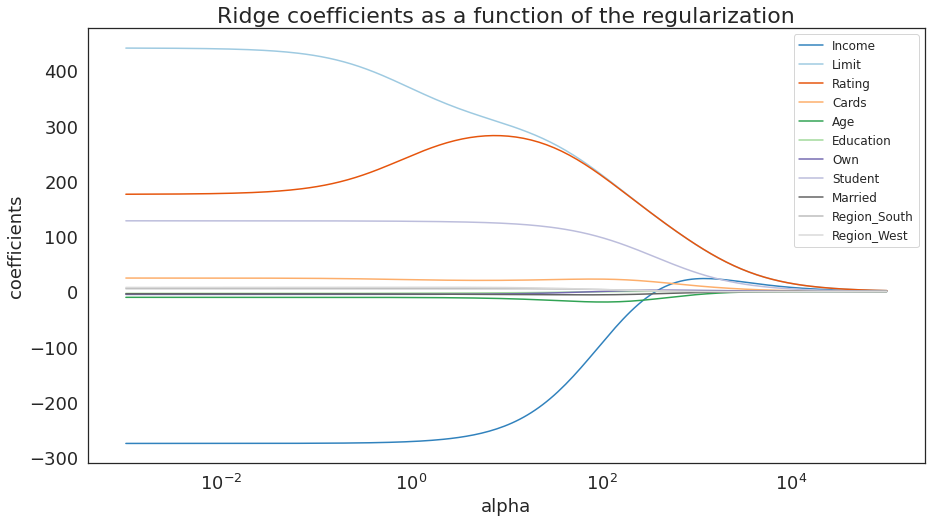

In [ ]:
# SOURCE: An Introduction to Statistical Learning, 2nd Edition Figure 6.4

# Plot paths of coefficients as a function of regularization
ax = ridge_coefs.drop('Intercept', axis=1).plot(figsize=(15,8), colormap='tab20c', logx=True, xlabel='alpha', ylabel='coefficents', fontsize=18);
ax.set_xlabel('alpha', fontdict={'fontsize':18})
ax.set_ylabel('coefficients', fontdict={'fontsize':18})
ax.set_title('Ridge coefficients as a function of the regularization', fontdict={'fontsize':22})
ax.legend(fontsize = 12);

# Exercise

## 1a. Use `scikit-learn` RidgeCV and **leave-one-out** cross-validation to find the optimal regularization strength, `alpha_`, and associated coefficents, `coef_`

## 1b. Use `scikit-learn` RidgeCV and **10-Fold** cross-validation to find the optimal regularization strength, `alpha_`, and associated coefficents, `coef_`

## `scikit-learn`: Lasso regression

In [ ]:
# SOURCE: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

# Create alphas (regularization strength)
n_alphas = 200
l_alphas = np.logspace(0, 3, n_alphas)
l_alphas

array([   1.        ,    1.03532184,    1.07189132,    1.1097525 ,
          1.148951  ,    1.18953407,    1.2315506 ,    1.27505124,
          1.3200884 ,    1.36671636,    1.4149913 ,    1.4649714 ,
          1.51671689,    1.57029012,    1.62575567,    1.68318035,
          1.74263339,    1.80418641,    1.8679136 ,    1.93389175,
          2.00220037,    2.07292178,    2.1461412 ,    2.22194686,
          2.30043012,    2.38168555,    2.46581108,    2.55290807,
          2.64308149,    2.73644   ,    2.8330961 ,    2.93316628,
          3.03677112,    3.14403547,    3.2550886 ,    3.37006433,
          3.48910121,    3.6123427 ,    3.7399373 ,    3.87203878,
          4.00880633,    4.15040476,    4.2970047 ,    4.44878283,
          4.60592204,    4.7686117 ,    4.93704785,    5.11143348,
          5.29197874,    5.47890118,    5.67242607,    5.87278661,
          6.08022426,    6.29498899,    6.5173396 ,    6.74754405,
          6.98587975,    7.2326339 ,    7.48810386,    7.75259

In [ ]:
# Compute paths
lasso_coefs = []
for a in l_alphas:
    lasso = Lasso(alpha=a, fit_intercept=False)
    lasso.fit(X, y)
    lasso_coefs.append(list(lasso.coef_.flatten()))

In [ ]:
predictors = ['Intercept', 'Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Own', 'Student', 'Married', 'Region_South', 'Region_West']

lasso_coefs = pd.DataFrame.from_dict(dict(zip(alphas, lasso_coefs))).T
lasso_coefs.columns = predictors
lasso_coefs

,Intercept,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region_South,Region_West
1.000000,519.015000,-270.401569,442.271460,169.423835,23.744727,-9.984784,-2.476759,-4.157883,126.768411,-2.990532,2.618047,4.746848
1.035322,518.979678,-270.237684,441.915489,169.609338,23.707239,-9.963863,-2.440833,-4.116507,126.726377,-2.952137,2.532063,4.657517
1.071891,518.943109,-270.068010,441.546944,169.801394,23.668427,-9.942203,-2.403638,-4.073669,126.682858,-2.912386,2.443042,4.565032
1.109752,518.905248,-269.892225,441.113696,170.051819,23.626031,-9.919833,-2.364866,-4.029322,126.637473,-2.871607,2.350910,4.469534
1.148951,518.866049,-269.710353,440.718594,170.257744,23.584426,-9.896616,-2.324997,-3.983405,126.590825,-2.828998,2.255489,4.370400
...,...,...,...,...,...,...,...,...,...,...,...,...
870.359136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000
901.101825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000
932.930403,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000
965.883224,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000


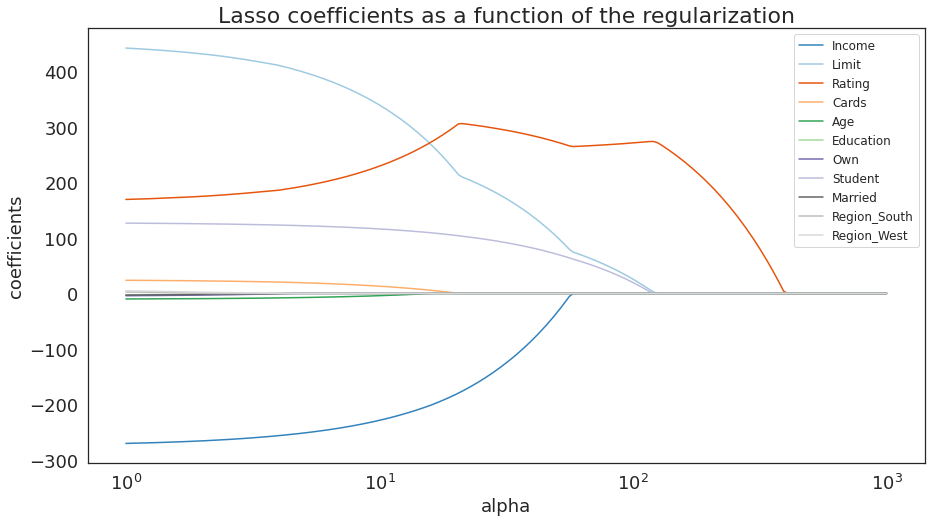

In [ ]:
# SOURCE: An Introduction to Statistical Learning, 2nd Edition Figure 6.6

# Plot paths of coefficients as a function of regularization
ax = lasso_coefs.drop('Intercept', axis=1).plot(figsize=(15,8), colormap='tab20c', logx=True, xlabel='alpha', ylabel='coefficents', fontsize=18);
ax.set_xlabel('alpha', fontdict={'fontsize':18})
ax.set_ylabel('coefficients', fontdict={'fontsize':18})
ax.set_title('Lasso coefficients as a function of the regularization', fontdict={'fontsize':22})
ax.legend(fontsize = 12);

## 2a. Use `scikit-learn` LassoCV and **leave-one-out** cross-validation to find the optimal regularization strength, `alpha_`, and associated coefficents, `coef_`

## 2b. Use `scikit-learn` LassoCV and **10-Fold** cross-validation to find the optimal regularization strength, `alpha_`, and associated coefficents, `coef_`

## `scikit-learn`: ElasticNet regression

In [ ]:
# SOURCE: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

# Create alphas (regularization strength)
n_alphas = 200
e_alphas = np.logspace(-3, 4, n_alphas)
e_alphas

array([1.00000000e-03, 1.08436597e-03, 1.17584955e-03, 1.27505124e-03,
       1.38262217e-03, 1.49926843e-03, 1.62575567e-03, 1.76291412e-03,
       1.91164408e-03, 2.07292178e-03, 2.24780583e-03, 2.43744415e-03,
       2.64308149e-03, 2.86606762e-03, 3.10786619e-03, 3.37006433e-03,
       3.65438307e-03, 3.96268864e-03, 4.29700470e-03, 4.65952567e-03,
       5.05263107e-03, 5.47890118e-03, 5.94113398e-03, 6.44236351e-03,
       6.98587975e-03, 7.57525026e-03, 8.21434358e-03, 8.90735464e-03,
       9.65883224e-03, 1.04737090e-02, 1.13573336e-02, 1.23155060e-02,
       1.33545156e-02, 1.44811823e-02, 1.57029012e-02, 1.70276917e-02,
       1.84642494e-02, 2.00220037e-02, 2.17111795e-02, 2.35428641e-02,
       2.55290807e-02, 2.76828663e-02, 3.00183581e-02, 3.25508860e-02,
       3.52970730e-02, 3.82749448e-02, 4.15040476e-02, 4.50055768e-02,
       4.88025158e-02, 5.29197874e-02, 5.73844165e-02, 6.22257084e-02,
       6.74754405e-02, 7.31680714e-02, 7.93409667e-02, 8.60346442e-02,
      

In [ ]:
# SOURCE: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html

# l1_ratio = 0 is the Ridge penalty
# l1_ratio = 1 is the Lasso penalty
l1_ratios = [.1, .5, .7, .9, .95, .99, 1] # [0.05, 0.25, 0.5, 0.75, 0.95]
l1_ratios

[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]

In [ ]:
# Compute paths
enet_ratios = {}
for r in l1_ratios:
    enet_coefs = []
    for a in l_alphas:
        enet = ElasticNet(alpha=a, l1_ratio=r, fit_intercept=False)
        enet.fit(X, y)
        enet_coefs.append(list(enet.coef_.flatten()))
    enet_ratios[r] = enet_coefs

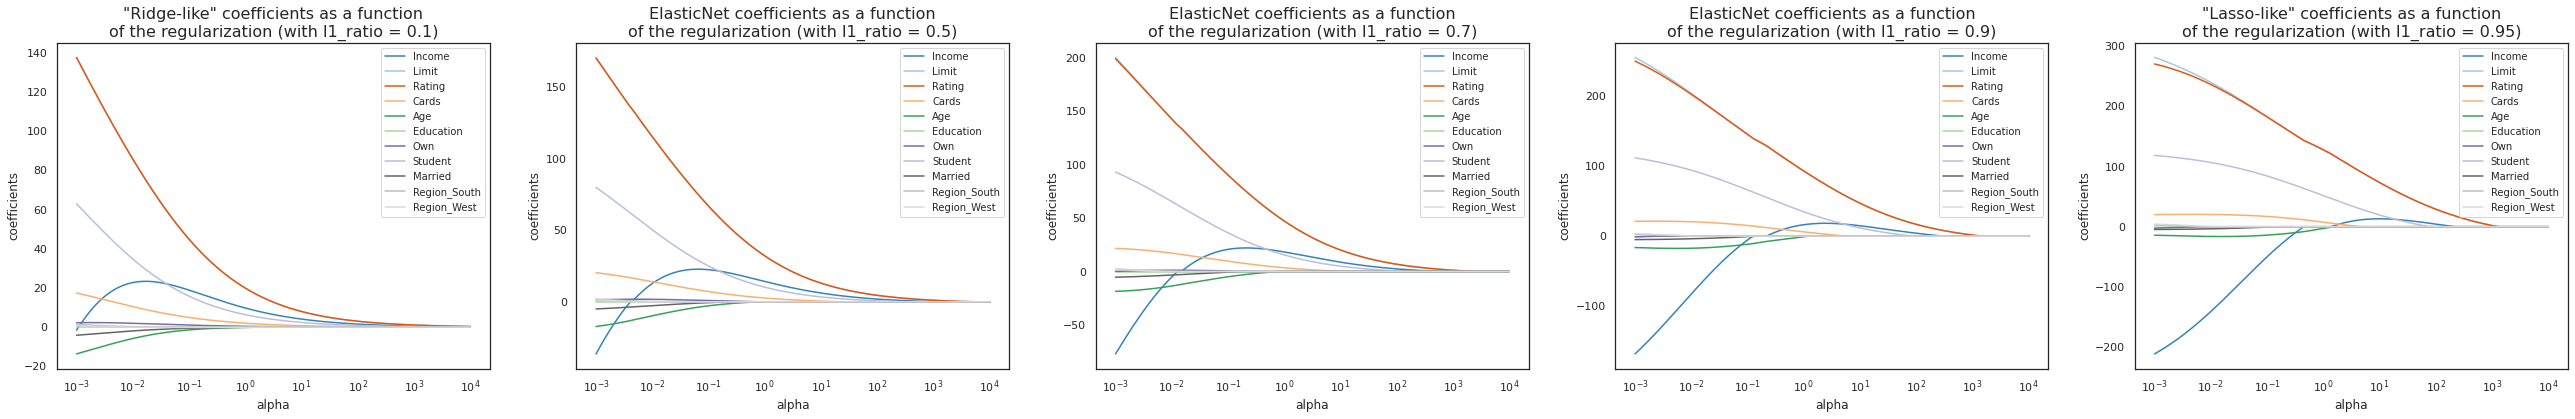

In [ ]:
fig, axs = plt.subplots(figsize=(45,6), ncols=5)

predictors = ['Intercept', 'Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Own', 'Student', 'Married', 'Region_South', 'Region_West']

# Plot paths of coefficients as a function of regularization
# alpha = 0 is equivalent to OLS
# l1_ratio = 0 is the Ridge penalty
# l1_ratio = 1 is the Lasso penalty
for i, ax in enumerate(axs.flat):
    enet_coefs = pd.DataFrame.from_dict(dict(zip(e_alphas, enet_ratios[l1_ratios[i]]))).T
    enet_coefs.columns = predictors
    ax = enet_coefs.drop('Intercept', axis=1).plot(ax=ax, colormap='tab20c', logx=True, xlabel='alpha', ylabel='coefficents');
    ax.set_xlabel('alpha', fontdict={'fontsize':12})
    ax.set_ylabel('coefficients', fontdict={'fontsize':12})
    if i == 0:
        ax.set_title('"Ridge-like" coefficients as a function\nof the regularization (with l1_ratio = {})'.format(l1_ratios[i]), fontdict={'fontsize':16})
    elif i == 4:
        ax.set_title('"Lasso-like" coefficients as a function\nof the regularization (with l1_ratio = {})'.format(l1_ratios[i]), fontdict={'fontsize':16})
    else:
        ax.set_title('ElasticNet coefficients as a function\nof the regularization (with l1_ratio = {})'.format(l1_ratios[i]), fontdict={'fontsize':16})
    ax.legend(fontsize = 10);

## 3a. Use `scikit-learn` ElasticNetCV and **leave-one-out** cross-validation to find the optimal regularization strength, `alpha_`, the compromise between l1 and l2 penalization, `l1_ratio_`, and associated coefficents, `coef_`

In [1]:
# For l1_ratio = 0 the penalty is an L2 penalty. 
# For l1_ratio = 1 it is an L1 penalty. 
# For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2


## 3b. Use `scikit-learn` ElasticNetCV and **10-Fold** cross-validation to find the optimal regularization strength, `alpha_`, the compromise between l1 and l2 penalization, `l1_ratio_`, and associated coefficents, `coef_`

In [2]:
# For l1_ratio = 0 the penalty is an L2 penalty. 
# For l1_ratio = 1 it is an L1 penalty. 
# For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2
